Attempt at the max_ratio methodology to identify the optimal number of clusters.

In [1]:
# pip install torchmetrics
# pip install stepmix
# pip install kneed
# pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from joblib import Parallel, delayed # for parallelization
from itertools import product

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from stepmix.stepmix import StepMix
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from scipy.spatial.distance import mahalanobis

# Evaluation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import BallTree
import torch
from torchmetrics.clustering import DunnIndex
from collections import Counter
from kneed import KneeLocator

# Visualization
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Preparation
## Data

In [2]:
data2004_i = pd.read_parquet("data/data2004_i.parquet") # load imputed data

# Dataset with numeric outcomes
data_n = data2004_i[[
    # Q2
    'clseusa_n', # 'clsetown_n', 'clsestat_n', 'clsenoam_n',
    # Q3
    'ambornin_n', 'amcit_n', 'amlived_n', 'amenglsh_n', 
    'amchrstn_n', 'amgovt_n', 'amfeel_n', # 'amancstr_n',
    # Q4
    'amcitizn_n', 'amshamed_n', 'belikeus_n', 'ambetter_n', 'ifwrong_n', # 'amsports_n', 'lessprd_n',
    # Q5
    'proudsss_n', 'proudgrp_n', 'proudpol_n', 'prouddem_n', 'proudeco_n',
    'proudspt_n', 'proudart_n', 'proudhis_n', 'proudmil_n', 'proudsci_n']]

# Dataset with categorical outcomes
data_f = data2004_i[[
    # Q2
    'clseusa_f', # 'clsetown_f', 'clsestat_f', 'clsenoam_f',
    # Q3
    'ambornin_f', 'amcit_f', 'amlived_f', 'amenglsh_f', 
    'amchrstn_f', 'amgovt_f', 'amfeel_f', # 'amancstr_f',
    # Q4
    'amcitizn_f', 'amshamed_f', 'belikeus_f', 'ambetter_f', 'ifwrong_f', # 'amsports_f', 'lessprd_f',
    # Q5
    'proudsss_f', 'proudgrp_f', 'proudpol_f', 'prouddem_f', 'proudeco_f',
    'proudspt_f', 'proudart_f', 'proudhis_f', 'proudmil_f', 'proudsci_f']]

# Dataset with controls
controls = data2004_i[[
    'sex', 'race_f', 'born_usa', 'party_fs', 'religstr_f', 
    'reltrad_f', 'region_f']]

## Parameters

In [3]:
max_clust = 12
max_threads = 8

val_indexes = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn', 'inertia']

## Validity indexes

In [4]:
# Custom score functions to avoid throwing errors when undefined
def sil_score(data, pred_clust):
    try:
        sil_score = silhouette_score(data, pred_clust)
    except ValueError:
        sil_score = np.nan
    return sil_score

def ch_score(data, pred_clust):
    try:
        ch_score = calinski_harabasz_score(data, pred_clust)
    except ValueError:
        ch_score = np.nan
    return ch_score

def db_score(data, pred_clust):
    try:
        db_score = davies_bouldin_score(data, pred_clust)
    except ValueError:
        db_score = np.nan
    return db_score

def dunn_score(data, pred_clust):
    torch_data = np.array(data)
    torch_data = torch.tensor(torch_data, dtype=torch.float32)
    torch_pred_clust = torch.tensor(pred_clust, dtype=torch.int64)

    dunn_metric = DunnIndex()
    
    try:
        dunn_score = float(dunn_metric(torch_data, torch_pred_clust))
    except Exception:
        dunn_score = np.nan
 
    return dunn_score

def inertia(data, labels):
    data = np.asarray(data)
    
    inertia = 0
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        cluster_centroid = np.mean(cluster_points, axis=0)
        inertia += np.sum((cluster_points - cluster_centroid) ** 2)
        
    return inertia

def clust_size(labels):
    cluster_sizes = Counter(labels)
    min_size = min(cluster_sizes.values())
    max_size = max(cluster_sizes.values())
    
    return min_size, max_size

In [5]:
# Function to return all validity indexes at once
def get_metrics(model, params, n, data, pred_clust, **additional_metrics):
    base_metrics = {
        'model': model,
        'params': params,
        'n_clust': n,
        'min_clust_size': clust_size(pred_clust)[0],
        'max_clust_size': clust_size(pred_clust)[1],
        'silhouette': sil_score(data, pred_clust),
        'calinski_harabasz': ch_score(data, pred_clust),
        'davies_bouldin': db_score(data, pred_clust),
        'dunn': dunn_score(data, pred_clust),
        'inertia': inertia(data, pred_clust)
    }

    base_metrics.update(additional_metrics)
    return base_metrics

## Visualization

In [6]:
# Function to display the optimal numbers of clutsters according to each validity index
def elbow_plot(df, val_index):
    res = df.dropna(subset=[val_index])

    x = res["n_clust"]
    y = res[val_index]

    if val_index in ['davies_bouldin', 'entropy']:
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')

    plt.figure(figsize=(8, 4))
    plt.plot(x, y, marker="o", linestyle="-", label=val_index)
    plt.axvline(x=knee_locator.knee, color="r", linestyle="--", label=f"Optimal k={knee_locator.knee}")
    plt.xlabel("Number of Clusters")
    plt.ylabel(f"{val_index} index")
    plt.title(f"Elbow Method for {val_index} index")
    plt.legend()
    plt.show()

# Latent class models
With the StepMix package, see: https://github.com/Labo-Lacourse/stepmix

In [8]:
# Parameters
clust_range = range(1, max_clust+1)

opt_params = {
    'method': 'gradient',
    'intercept': True,
    'max_iter': 2500,
}

In [ ]:
# Fit models without covariates
def do_StepMix(n, type, data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        latent_mod = StepMix(
            n_components = n, 
            measurement = type, 
            n_init = 3,
            init_params = 'kmeans',
            structural_params = opt_params,
            random_state = 123)
        
        latent_mod.fit(data)
        pred_clust = latent_mod.predict(data)

        model = 'LCA' if type == 'categorical' else 'LPA'
        params = 'without covariates'
        loglik = latent_mod.score(data)
        aic = latent_mod.aic(data)
        bic = latent_mod.aic(data)
        entropy = latent_mod.entropy(data)

    return get_metrics(model, params, n, data, pred_clust, LL = loglik, aic = aic, bic = bic, entropy = entropy)

data = data_f.apply(lambda col: LabelEncoder().fit_transform(col))
cat_results = Parallel(n_jobs=8)(delayed(do_StepMix)(n, 'categorical', data) for n in clust_range)
LCA_all = pd.DataFrame(cat_results)

# Data preprocessing?
num_results = Parallel(n_jobs=8)(delayed(do_StepMix)(n, 'continuous', data_n) for n in clust_range)
LPA_all = pd.DataFrame(num_results)

# Best models according to max_ratio

In [60]:
from scipy.interpolate import CubicSpline

df = LCA_all
val_index = 'bic'

# Models selection
models = df.dropna(subset=[val_index])

# Spline interpolation
cs = CubicSpline(models['n_clust'], models[val_index])
interpol_n = np.array([min(clust_range), max(clust_range)+1])

interpol_df = pd.DataFrame({
    'model': 'LCA',
    'params': 'without covariates',
    'n_clust': interpol_n,
    val_index: cs(interpol_n)
})

models = pd.concat([models, interpol_df]).sort_values('n_clust')

# max_ratio computation
results = []
for i in range (min(clust_range)+1,max(clust_range)+1):
    CV0 = models[models['n_clust'] == i-1][val_index].values[0]
    CV1 = models[models['n_clust'] == i][val_index].values[0]
    CV2 = models[models['n_clust'] == i+1][val_index].values[0]
    max_ratio = (CV1 - CV0)/(CV2 - CV1)
    results.append(float(max_ratio))

results = pd.DataFrame({
    'n_clust': range(min(clust_range)+1,max(clust_range)+1),
    'max_ratio': results
})

# Find optimal k
opt_n = results.loc[results['max_ratio'].idxmax(), 'n_clust']
float(opt_n)

8.0

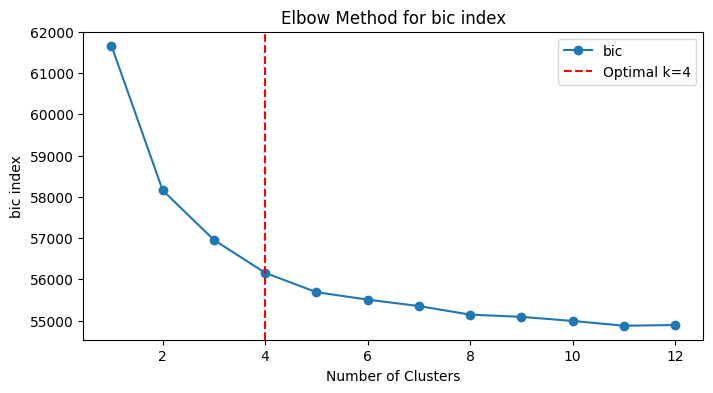

In [61]:
elbow_plot(LCA_all, val_index)

max_ratio tends to select (much) higher values of k than the elbow method

dunn: MR=2 / elbow=3

silhouette: MR=11 / elbow=3

calinski_harabasz: MR=6 / elbow=6

davies_bouldin: MR=2 / elbow=3

inertia: MR=12 / elbow=4

aic: MR=8 / elbow=4

bic: MR=8 / elbow=4

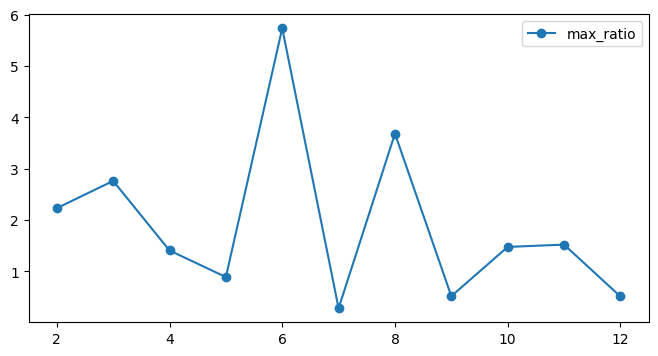

In [53]:
# Plot the max ratio
x = results['n_clust']
y = results['max_ratio']

plt.figure(figsize=(8, 4))
plt.plot(x, y, marker="o", linestyle="-", label='max_ratio')
plt.legend()
plt.show()

In [48]:
# Find the best model for each combination of parameters through the Elbow method
def elbow_method(df, val_index):
    res = df.dropna(subset=[val_index])

    x = res["n_clust"]
    y = res[val_index]

    if val_index in ['davies_bouldin', 'entropy']:
        knee_locator = KneeLocator(x, y, curve='concave', direction='increasing')
    else:
        knee_locator = KneeLocator(x, y, curve='convex', direction='decreasing')
    
    return res[res["n_clust"] == knee_locator.knee]

models = [LCA_all, LPA_all] # + [LCA_covar_all, LPA_covar_all]
params = product(models, val_indexes + ['aic', 'bic', 'entropy'])

latent_elbow = pd.DataFrame()
for model, val_index in params:
    best_model = elbow_method(model, val_index)
    latent_elbow = pd.concat([latent_elbow, best_model], ignore_index=True)

In [49]:
# Find absolute best models for each validity index
latent_elbow = latent_elbow.drop_duplicates().reset_index(drop=True)
# Need to add colums indicating which validity index is maximized.
# After that, duplicate models should be merged, not dropped.

best_silhouette = latent_elbow.sort_values('silhouette', ascending=False).iloc[0]
best_ch = latent_elbow.sort_values('calinski_harabasz', ascending=False).iloc[0]
best_db = latent_elbow.sort_values('davies_bouldin', ascending=True).iloc[0]
best_dunn = latent_elbow.sort_values('dunn', ascending=False).iloc[0]
best_inertia = latent_elbow.sort_values('inertia', ascending=False).iloc[0]

best_aic = latent_elbow.sort_values('aic', ascending=True).iloc[0]
best_bic = latent_elbow.sort_values('bic', ascending=True).iloc[0]
best_entropy = latent_elbow.sort_values('entropy', ascending=False).iloc[0]

latent_best = pd.DataFrame([best_silhouette, best_ch, best_db, best_dunn, best_inertia])
latent_best = latent_best.drop_duplicates().reset_index(drop=True)

In [50]:
latent_best

,model,params,n_clust,min_clust_size,max_clust_size,silhouette,calinski_harabasz,davies_bouldin,dunn,inertia,LL,aic,bic,entropy
0,LPA,without covariates,3,239,558,0.069649,106.252173,3.243625,0.249888,25218.333831,-18.615251,45515.059593,45515.059593,43.265788
1,LCA,without covariates,3,253,527,0.050062,126.102058,3.165817,0.195118,24374.255479,-23.209650,56955.449635,56955.449635,186.249380
2,LCA,without covariates,4,105,432,0.050236,104.346795,3.006889,0.228913,23397.961936,-22.804706,56157.435618,56157.435618,194.329094
